In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from segmentflow import segment, view
from skimage import color
from stl import mesh
%load_ext autoreload
%autoreload 2

In [2]:
img_dir_path = Path('../data/SandComp4_18_22/NoComptiff/')
save_dir_path = Path('../data/SandComp4_18_22/')

## Generate STLs

Loading images...
--> Images loaded as 3D array:  (50, 50, 50)
Plotting images: [0, 12, 24, 36]


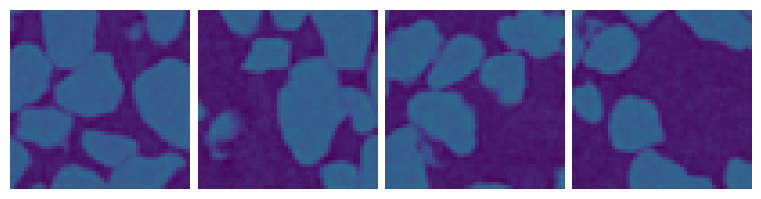

In [3]:
# row & col crop deterined in NB 09
imgs = segment.load_images(
    img_dir_path,
    slice_crop=[125, 175],
    row_crop=[450, 500],
    col_crop=[200, 250],
    convert_to_float=True,
    file_suffix='.tiff'
)
fig, axes = view.plot_slices(
    imgs,
    nslices=4,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

Binarizing images...
--> Calculating Otsu threshold(s)...
--> Binarization complete.
Plotting images: [0, 12, 24, 36]


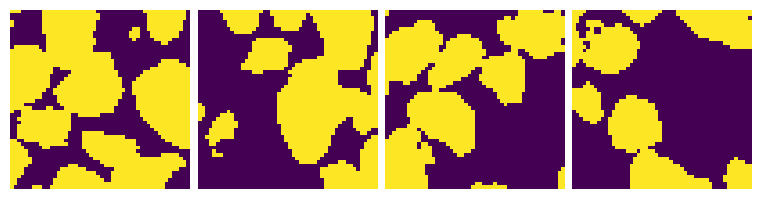

In [4]:
imgs_bw, thresh_vals = segment.binarize_multiotsu(imgs, n_otsu_classes=2)
fig, axes = view.plot_slices(
    imgs_bw,
    nslices=4,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

Segmenting images...
--> Number of particle(s) before border exclusion:  23
--> Excluding border particles...
--> Segmentation complete. 3 particle(s) segmented.
Plotting images: [0, 12, 24, 36]


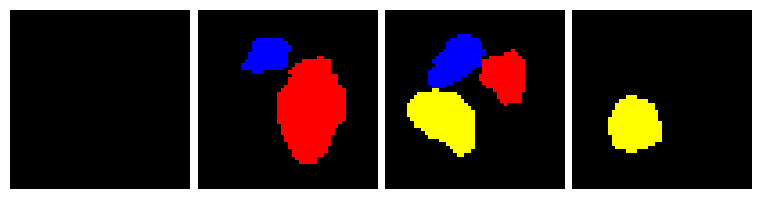

In [5]:
imgs_seg = segment.watershed_segment(
    imgs_bw,
    min_peak_distance=7,
    exclude_borders=True,
    return_dict=False
)
imgs_seg_color = color.label2rgb(imgs_seg)
fig, axes = view.plot_slices(
    imgs_seg_color,
    nslices=4,
    print_slices=True,
    imgs_per_row=None,
    fig_w=7.5,
    dpi=100
)

In [6]:
segment.save_as_stl_files(
    imgs_seg,
    save_dir_path,
    f'{img_dir_path.stem}-',
    make_new_save_dir=True
)

Generating surface meshes...
Meshes not generated. Directory already exists:
C:\Users\gusb\Research\mhe-analysis\data\SandComp4_18_22\NoComptiff-STLs


## Dev vector assembly

In [7]:
stl_dir_path = Path(f'{save_dir_path}/{img_dir_path.stem}-STLs')
stl_dir_list = [path for path in stl_dir_path.glob('*.stl')]
stl_dir_list.sort()
stl_path = stl_dir_list[0]
stl_mesh = mesh.Mesh.from_file(stl_path)
print(stl_mesh.vectors.shape)
print(stl_mesh.vectors[0])
print(stl_mesh.v0.shape)
print(stl_mesh.v0)

(5568, 3, 3)
[[32.  21.5  6. ]
 [31.5 22.   6. ]
 [32.  22.   5.5]]
(5568, 3)
[[32.  21.5  6. ]
 [32.  22.   5.5]
 [31.  22.5  6. ]
 ...
 [36.  18.5 29. ]
 [37.  18.5 29. ]
 [37.  18.5 29. ]]


In [8]:
test = stl_mesh.vectors[:2]
print(test.shape)
print(test)
test1 = test.reshape((test.shape[0] * test.shape[2], test.shape[1]))
print(test1)
print(np.unique(test1, axis=0))

(2, 3, 3)
[[[32.  21.5  6. ]
  [31.5 22.   6. ]
  [32.  22.   5.5]]

 [[32.  22.   5.5]
  [32.5 22.   6. ]
  [32.  21.5  6. ]]]
[[32.  21.5  6. ]
 [31.5 22.   6. ]
 [32.  22.   5.5]
 [32.  22.   5.5]
 [32.5 22.   6. ]
 [32.  21.5  6. ]]
[[31.5 22.   6. ]
 [32.  21.5  6. ]
 [32.  22.   5.5]
 [32.5 22.   6. ]]


In [9]:
# -1 in np.reshape() infers remaining dimension from size of original array
vectors = stl_mesh.vectors.reshape((-1, stl_mesh.vectors.shape[1]))
print(vectors.shape)
vectors = np.unique(vectors, axis=0)
print(vectors.shape)

(16704, 3)
(2786, 3)


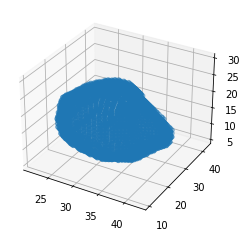

In [10]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2])

[31.602297 25.400574 15.779613]


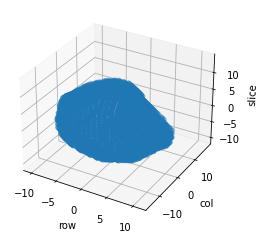

In [35]:
center = np.mean(vectors, axis=0)
print(center)
centered = vectors - center
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('row')
ax.set_ylabel('col')
ax.set_zlabel('slice')
ax.scatter(centered[:, 0], centered[:, 1], centered[:, 2])

<Figure size 432x288 with 0 Axes>

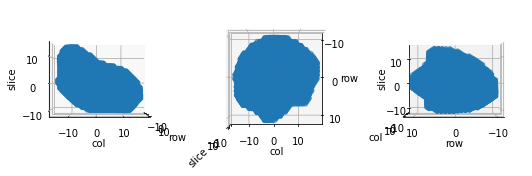

In [42]:
fig = plt.figure()
fig, axes = plt.subplots(1, 3, figsize=(9, 3), subplot_kw=dict(projection='3d'))
for a in axes:
    a.scatter(centered[:, 0], centered[:, 1], centered[:, 2])
    a.set_xlabel('row')
    a.set_ylabel('col')
    a.set_zlabel('slice')
axes[0].view_init(0, 0)
axes[1].view_init(90, 0)
axes[2].view_init(0, 90)

In [29]:
tp_list = [
    np.tensordot(centered[i, :], centered[i, :], axes=0)
    for i in range(centered.shape[0])
]
tp_mean = np.mean(np.stack(tp_list), axis=0)
print(tp_mean.shape)
print(tp_mean)

(3, 3)
[[ 32.259823  -5.568617   2.713139]
 [ -5.568617  76.827225 -21.511494]
 [  2.713139 -21.511494  42.03914 ]]


In [48]:
evals, evecs = np.linalg.eig(tp_mean)
print(evals)
print(evecs)

[87.788155 31.557533 31.780502]
[[ 1.10862836e-01 -9.68272686e-01  2.23958656e-01]
 [-8.96825433e-01 -3.60222883e-04  4.42384422e-01]
 [ 4.28268075e-01  2.49895811e-01  8.68411481e-01]]


In [32]:
radii = np.sqrt(evals)
print(radii)

[9.369534  5.617609  5.6374197]


In [99]:
# Eigen-vector (principal axis mag) scaled by eigen-value (length of axis)
scaled_axes = []
for j in range(3):
    scaled_axes.append(radii[j] * evecs[j])
scaled_axes = np.stack(scaled_axes)
scaled_axes

array([[ 1.0387330e+00, -9.0722637e+00,  2.0983882e+00],
       [-5.0380144e+00, -2.0235914e-03,  2.4851427e+00],
       [ 2.4143269e+00,  1.4087676e+00,  4.8955998e+00]], dtype=float32)

<Figure size 432x288 with 0 Axes>

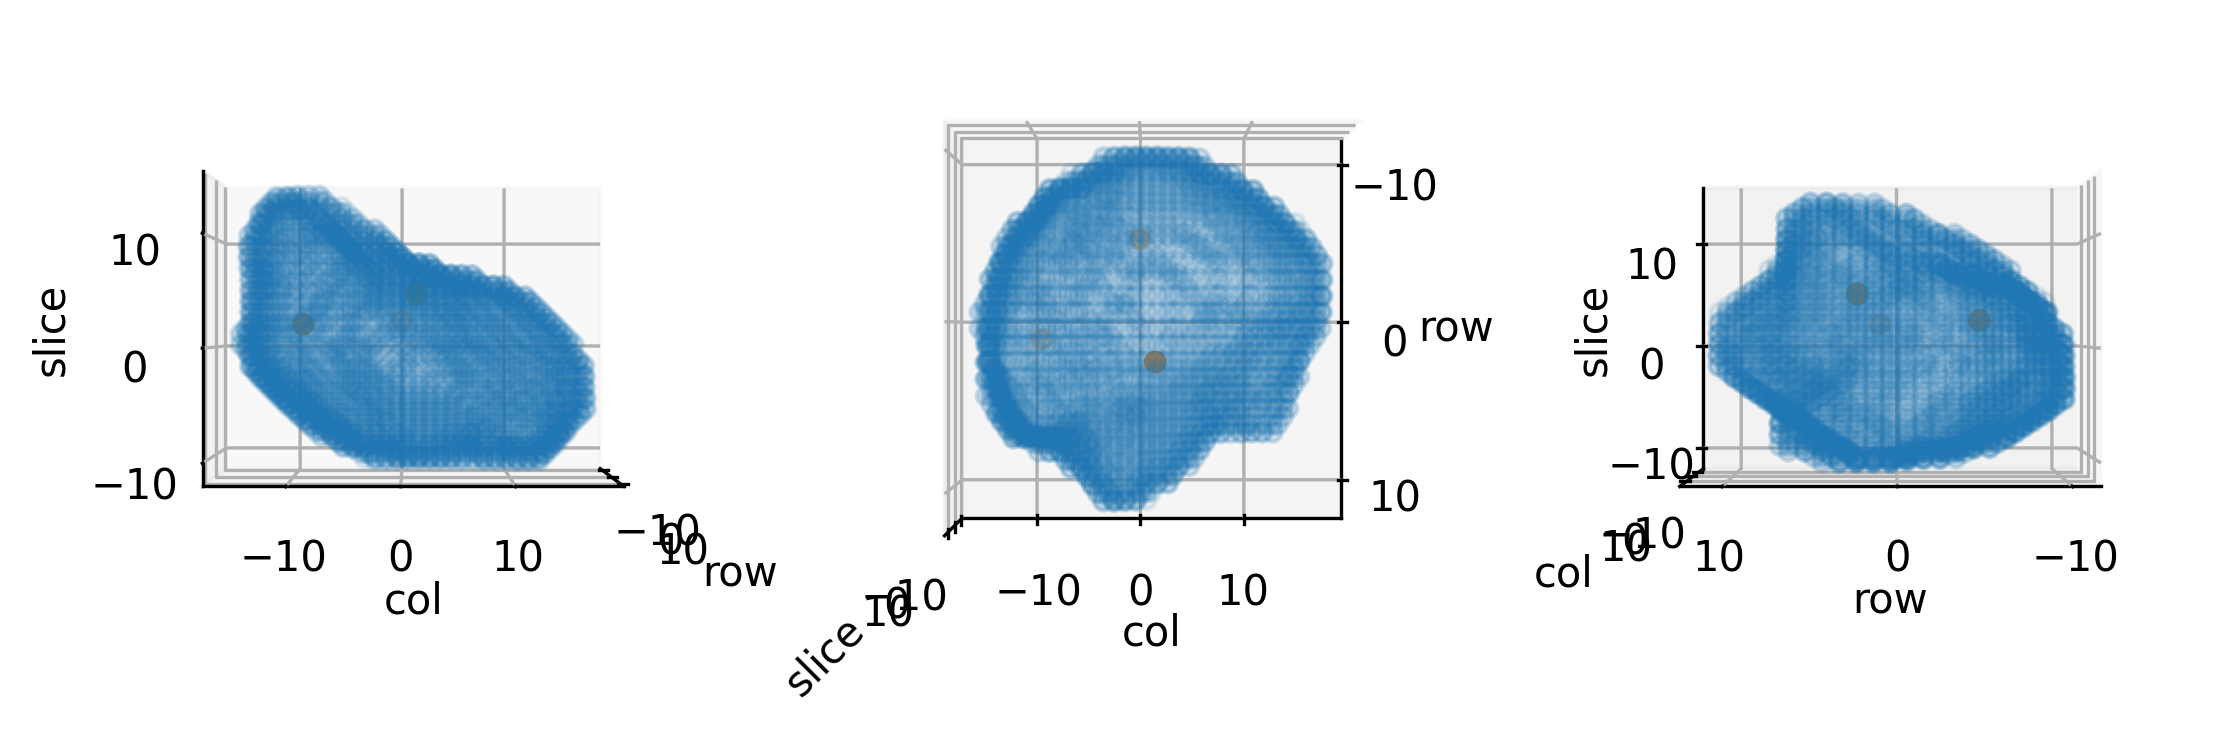

In [103]:
fig = plt.figure()
fig, axes = plt.subplots(1, 3, figsize=(9, 3), subplot_kw=dict(projection='3d'), dpi=300)
for i, a in enumerate(axes):
    a.scatter(centered[:, 0], centered[:, 1], centered[:, 2], alpha=0.1)
    a.scatter(scaled_axes[:, 0], scaled_axes[:, 1], scaled_axes[:, 2], c='C1')
    a.set_xlabel('row')
    a.set_ylabel('col')
    a.set_zlabel('slice')
axes[0].view_init(0, 0)
axes[1].view_init(90, 0)
axes[2].view_init(0, 90)

I was hoping the principal axes defined by the would be closer to the shell of
the particle, but this doesn't seem to be the case. Moving back to
approximating particle size with cross-sectional area of sphere of matching
volume for now.